In [2]:
import numpy as np
import seaborn as sns
import mdtraj as md
import matplotlib.pyplot as plt
import nglview as nv
import pytraj as pt

# https://biopython.org/docs/1.74/api/Bio.SVDSuperimposer.html
from Bio.SVDSuperimposer import SVDSuperimposer

from numpy import array, dot, set_printoptions

In [3]:
# Load H-NS dimers
loc_dimers = './dimer_pdbs/'
dimers = md.join([md.load(loc_dimers+f'run{i}.pdb') for i in range(0,16)])

# Load H-NS DBD attached to DNA
loc_complexes = '/Users/thor/surfdrive/Scripts/notebooks/HNS-sequence/WorkingDir/data/MD/HNS_and_DNA/FI_sims/cAT-1_WT/drytrajs/'
i = 'long'
complexes = md.load(loc_complexes+f'dry_{i}.xtc', top=loc_complexes+f'dry_{i}.pdb')

In [4]:
# Show complexes
view = nv.show_mdtraj(complexes)
view

NGLWidget(max_frame=20000)

In [5]:
# Show dimers
view = nv.show_mdtraj(dimers)
view

NGLWidget(max_frame=15)

In [6]:
# Define which dimer you want to attach
target = dimers[0]

In [7]:
# Select dimer frame and which monomer (0 or 1)
idx = 11
chain = 0

# Extract xyz coordinates of first frame complex and idx dimer
xyz_A = complexes[0].xyz[0].T
xyz_B = dimers[idx].xyz[0].T

In [9]:
# Get indices of atoms to fit, in this case only the last 48 residues, which coincide with the DBD
idx_set_A  = [at.index for res in complexes.top._chains[2]._residues[-48:] for at in res.atoms]
idx_set_B  = [at.index for res in dimers.top._chains[chain]._residues[-48:] for at in res.atoms]

atom_set_A = complexes[0].atom_slice(idx_set_A).xyz[0].T
atom_set_B = dimers[idx].atom_slice(idx_set_B).xyz[0].T

In [10]:
# load super imposer
sup = SVDSuperimposer()


# Set the coords y will be rotated and translated on x
x = atom_set_A.T
y = atom_set_B.T
sup.set(x, y)

# Do the lsq fit
sup.run()

# Get the rms
rms = sup.get_rms()

# Get rotation (right multiplying!) and the translation
rot, tran = sup.get_rotran()

# Rotate y on x
y_on_x1 = dot(y, rot) + tran

# Same thing
y_on_x2 = sup.get_transformed()

print('rms',"%.2f" % rms)

rms 0.40


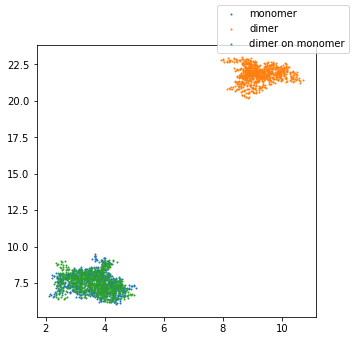

In [13]:
fig,ax=plt.subplots(figsize=[5,5])
ax.scatter(atom_set_A[2],atom_set_A[1],s=1,label='monomer')
ax.scatter(atom_set_B[2],atom_set_B[1],s=1,label='dimer')
ax.scatter(y_on_x2.T[2],y_on_x2.T[1],s=1,label='dimer on monomer')
fig.legend()

In [15]:
a = xyz_A.T
b = xyz_B.T

# rotate b on a
b_on_a1 = dot(b, rot) + tran

# replace coordinates 
dimers.xyz[idx] = b_on_a1

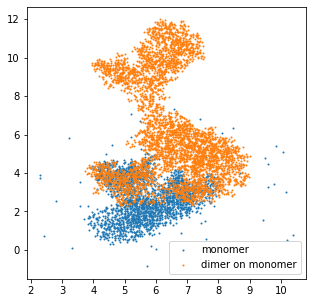

In [17]:
fig,ax=plt.subplots(figsize=[5,5])
i = 0
j = 2
ax.scatter(xyz_A[i],xyz_A[j],s=1,label='monomer')
#ax.scatter(xyz_B[i],xyz_B[j],s=1,label='dimer')
ax.scatter(b_on_a1.T[i],b_on_a1.T[j],s=1,label='dimer on monomer')
ax.legend()

In [19]:
# make new frame with fitted dimer and DNA, aka merge complex and dimer and remove monomer
test = complexes[0].stack(dimers[idx])
view = nv.show_mdtraj(test)
view

NGLWidget()

In [20]:
selection = [at.index for idx,chain in enumerate(test.top.chains) if idx != 2 for at in chain.atoms]
# probably easiest to use atomslice to remove/delete monomer
final = test.atom_slice(selection)
show = [at.index for at in final.top._chains[3].atoms]
view = nv.show_mdtraj(final)
view.add_licorice(selection=show)
view

NGLWidget()